# $\mathbb{Z}_{2}$-symmetric singlet extension of the Standard Model ($\mathbb{Z}_{2}$-RxSM)

In [ ]:
from Higgs.tools.ImplementationUtils import implementMeasurement
from Higgs.tools.MeasurementValidation import *
import Higgs.signals as HS
import Higgs.bounds as HB
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rc("axes",labelsize="large")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 600

import os
os.chdir('/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections/')
# os.getcwd()

## Likelihood calculator

In [2]:
pred = HP.Predictions()
# bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
signals = HS.Signals('hsdataset') # load HS dataset

h = pred.addParticle(HP.NeutralScalar("h", "even"))
h.setMass(125)

coups = HP.scaledSMlikeEffCouplings(1)
HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")

chisqSM = signals(pred)


def getChisq(kappas, signals):

    for key in kappas.keys():
        if not key in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg', "lam"]:
            continue
        else:
            setattr(coups, key, kappas[key])
        
    HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    return signals(pred)

## Plotting function

In [3]:
from scipy import interpolate
import scipy.stats 
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D

#### Useful auxiliary statistics functions

In [4]:
def confidence_level(nsigma):
    r"""Return the confidence level corresponding to a number of sigmas,
    i.e. the probability contained in the normal distribution between $-n\sigma$
    and $+n\sigma$.

    Example: `confidence_level(1)` returns approximately 0.68."""
    return (scipy.stats.norm.cdf(nsigma)-0.5)*2

def delta_chi2(nsigma, dof):
    r"""Compute the $\Delta\chi^2$ for `dof` degrees of freedom corresponding
    to `nsigma` Gaussian standard deviations.

    Example: For `dof=2` and `nsigma=1`, the result is roughly 2.3."""
    if dof == 1:
        # that's trivial
        return nsigma**2
    chi2_ndof = scipy.stats.chi2(dof)
    cl_nsigma = confidence_level(nsigma)
    return chi2_ndof.ppf(cl_nsigma)

def chi2_prob(chi2, dof):
    r"""Compute the probability the the chi2 value is equal or larger than `chi2'
    for `dof' degrees of freedom"""
    chi2_ndof = scipy.stats.chi2(dof)
    return 1 - chi2_ndof.cdf(chi2)

def chi2_prob_sigma(chi2, dof):
    r"""Compute the probability the the chi2 value is equal or larger than `chi2'
    for `dof' degrees of freedom"""
    chisq_probability = 1 - chi2_prob(chi2, dof)
    print(chisq_probability)
    chi2_1D = scipy.stats.chi2(1)
    return np.sqrt(chi2_1D.ppf(chisq_probability))

# print(delta_chi2(nsigma=1, dof=2))
# print(chi2_prob(6.180074, 2))

# chi2_1D = scipy.stats.chi2(1)
# print(chi2_1D.ppf(0.5))
chi2_prob_sigma(6.18,2)
chi2_prob_sigma(10.423363,9)

chi2_prob_sigma(6.8, 2)
# delta_chi2(1, 9)

0.9544980455953784
0.6826894804456776
0.9666267300396739


np.float64(2.1275637558787523)

In [5]:
def read_Z2SSM_file(df, loop_order=2):

    kappas = {}
    EWPOs = {}

    if loop_order==1:
        kappas["lam"] = df['kappaLam1L']

        for fermion in ['uu', 'dd', 'ss', 'cc', 'bb', 'tt', 'ee', 'mumu', 'tautau']:
            kappas[fermion] = df['kappaSingleHiggs1L']

        kappas['ZZ']     = df['kappaSingleHiggs1L']
        kappas['WW']     = df['kappaSingleHiggs1L']
        kappas['gamgam'] = df['kappaSingleHiggs1L']
        kappas['Zgam']   = df['kappaSingleHiggs1L']
        kappas['gg']     = df['kappaSingleHiggs1L']

        for energy in ['0', '240', '365', '500', '550']:
            kappas['ZZ_' + energy] = df['kappaSingleHiggs1L'] + df['effZZh1Lkala_s' + energy]



        # EWPOs['Mw'] = df['MW1L']
        # EWPOs['sin2thetaEff'] = df['sl1L']
        # EWPOs['GammaZ'] = df['GamZ1L']


    elif loop_order==2:
        kappas["lam"] = df['kappaLam2L']

        for fermion in ['uu', 'dd', 'ss', 'cc', 'bb', 'tt', 'ee', 'mumu', 'tautau']:
            kappas[fermion] = df['kappaSingleHiggs2L']

        kappas['ZZ']     = df['kappaSingleHiggs2L']
        kappas['WW']     = df['kappaSingleHiggs2L']
        kappas['gamgam'] = df['kappaSingleHiggs2L']
        kappas['Zgam']   = df['kappaSingleHiggs2L']
        kappas['gg']     = df['kappaSingleHiggs2L']

        for energy in ['0', '240', '365', '500', '550']:
            kappas['ZZ_' + energy] = df['kappaSingleHiggs2L'] + df['effZZh2Lkala_s' + energy]

        # EWPOs['Mw'] = df['MW2L']
        # EWPOs['sin2thetaEff'] = df['sl2L']
        # EWPOs['GammaZ'] = df['GamZ2L']

    else:
        raise ValueError("Wrong loop order argument!")

    return kappas, EWPOs


# main plotting function
def plot_Z2SSM_bounds(data_file, 
                      plot_dir, 
                      signals, 
                      k_lambda_exp_error=0.25, 
                      zoom=False, 
                      full=False, 
                      zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                      zoom_range_y=(0.0, 0.005),
                      modified_central=False,
                      ndof=None,
                      chisq_max=12.,
                      plot_point=None):
    
    df = pd.read_csv(data_file + ".csv")

    df = df.replace("", np.nan)
    df = df.dropna().reset_index(drop=True)

    kappas, _ = read_Z2SSM_file(df)
    
    n_pts = df.shape[0]
    chisq = np.full((n_pts,), np.nan)
    for ind in range(n_pts):
        kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
        chisq[ind] = getChisq(kappas_row, signals)

    if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
    kappas_true = {}
    for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg', "lam"]:
        kappas_true[coup] = 1
    kappas_true["lam"] = 2

    chisq_true = getChisq(kappas_true, signals)
    if modified_central: chisq_true = getChisq(*modified_central, signals)
    chisq = chisq - chisq_true
    # y = [z if z < 12.001 else 12.001 for z in chisq]
    y = [z for z in chisq]
    df['col'] = y

    xscale = np.max(kappas['lam']) - np.min(kappas['lam'])
    yscale = np.max(kappas['ZZ'] - 1) - np.min(kappas['ZZ'] - 1)
    scale = np.array([xscale, yscale])

    mat = np.array([
        kappas['lam'].to_numpy(),
        kappas['ZZ'].to_numpy() - 1,
        df['col'].to_numpy()]).T
    
    grid_points = 300
    x = np.linspace(2 - 10*(2 - zoom_range_x[0]), 2 + 10*(zoom_range_x[1] - 2), grid_points)
    y = np.linspace(-0.02, 0.02, grid_points)
    X, Y = np.meshgrid(x, y)

    # Z = np.full((grid_points, grid_points), np.inf)
    # for i in range(grid_points):
    #     for j in range(grid_points):
    #         Z[i,j] = getChisq(x[i], 1-y[j], np.inf, signals)

    # Z = Z - chisq_true
    # Z = Z.T

    fig, ax = plt.subplots(
        figsize=(4.5, 4.),
        constrained_layout=True)

    # Rescaling colormap to avoid too-light points
    color_map = mpl.colormaps['GnBu_r']
    color_map = ListedColormap(color_map(np.linspace(0.0, 0.92, 256)))

    sc = ax.scatter(
        kappas['lam'],
        kappas['ZZ'] - 1,
        c=df['col'],
        s=0.4,
        cmap=color_map,
        # vmin=,
        vmax=chisq_max,
        rasterized=True)

    if zoom==False:
        # ax.set_xlim(np.min(kappas['lam']), np.max(kappas['lam']))
        ax.set_xlim(0, np.max(kappas['lam']))
        ax.set_ylim(np.min(kappas['ZZ'] - 1)-0.005, np.max(kappas['ZZ'] - 1))
    else:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    clb = fig.colorbar(
        sc,
        ax=ax,
        label=r"$\Delta\chi^2$",
        ticks=np.arange(0, chisq_max + 1, 1),
        pad=0,
        fraction=0.1,
        location='right',
        aspect=40,
        extend='max',
    )
    clb.ax.minorticks_on()

    if not ndof:
        if modified_central: ndof=1
        else: ndof=2
    print(ndof)
    levels_123sig = [delta_chi2(n_sigma, dof=ndof) for n_sigma in range(1, 3+1)]
    print(levels_123sig)

    # ax.contour(
    #     X,
    #     Y,
    #     Z,
    #     levels=levels_123sig,
    #     colors="black",
    #     linestyles=["-", "--", ":"],
    # )

 

    bfp_index = np.argmin(chisq)
    bfp_chisq = np.min(chisq)
    bfp = np.array([kappas['lam'][bfp_index], kappas['ZZ'][bfp_index] - 1])
    if modified_central: 
        plotted_point = list(modified_central)
        plotted_point[1] = plotted_point[1] - 1
    else: plotted_point = bfp

    ax.plot(
        *plotted_point,
        marker="*", ls="none", c="r")
    print(f"Best scan point: (k_Lamb = {bfp[0]:.10g}, (k_Z - 1) = {bfp[1]:.10g}), with chisq = {bfp_chisq:.3g}")
    print(f"Best scan point row: {bfp_index+2} out of {len(chisq)}")
    # print(f"Best scan point model parameters: muS={df["muS"][bfp_index]}, lamS={df["lamS"][bfp_index]}, lamSH={df["lamSH"][bfp_index]}")


    ax.set_xlabel(r'$\kappa_{\lambda}$')
    ax.set_ylabel(r'$\kappa_{Z} - 1$')

    if modified_central:
        chisq_SM = getChisq(1, 1, np.inf, signals) - chisq_true
        lower_text = fr"$\chi^{2}_{{\text{{SM}}}} = {{{chisq_SM:.2g}}}$ ({chi2_prob_sigma(chisq_SM, ndof):.2g}$\sigma$)"+'\n'+ \
                     f'{n_pts} Points'+'\n'+ \
                     r'Z2SSM'
        
    else:
        lower_text = f'{n_pts} Points'+'\n'+ \
                     fr'$\kappa^{{\text{{Exp}}}}_{{\lambda}}(\text{{HL-LHC}})=2\pm{{{k_lambda_exp_error:.2g}}}$'+'\n'+ \
                     r'Z2SSM'
    ax.text(
        0.97,
        0.05,
        lower_text,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=8
        )

    ax.text(
        0,
        1,
        r"$\mathrm{HiggsSignals}$",
        horizontalalignment="left",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    
    if modified_central:
        bfp_legend_label = "Central values"+"\n"+f"($\kappa_{{\lambda}}={modified_central[0]:.3g}$, $\kappa_{{Z}}-1={(modified_central[1]-1):.3g}$)"
    else:
        bfp_legend_label = fr"HS BFP ($\Delta\chi^2={bfp_chisq:.3g}$)"+"\n"+f"($\kappa_{{\lambda}}={bfp[0]:.3g}$, $\kappa_{{Z}}-1={bfp[1]:.3g}$)"

    percent = "\%" if plt.rcParams["text.usetex"] else "%"

    leg_handles = [
            Line2D([0], [0], color="k", ls="none", marker="*", c="r", 
                   label=bfp_legend_label),
            Line2D([0], [0], color="k", ls="-",  label=f"HS 68.3{percent} CL"),
            Line2D([0], [0], color="k", ls="--", label=f"HS 95.4{percent} CL"),
            Line2D([0], [0], color="k", ls=":",  label=f"HS 99.7{percent} CL"),
        ]

    legend_loc='best'
    if not plot_point is None:
        ax.plot(*plot_point, marker="*", ls="none", c="tab:orange")
        point_label = f"Benchmark Point\n($\kappa_{{\lambda}}={plot_point[0]:.3g}$, $\kappa_{{Z}}-1={plot_point[1]:.3g}$)"
        leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c="tab:orange", 
                   label=point_label))
        
        if zoom: legend_loc = 'center right'

    hsLegend = ax.legend(
        handles=leg_handles,
        loc=legend_loc,
        frameon=False,
        prop={'size': 7}
    )
    ax.add_artist(hsLegend)


    plot_name = f'Z2SSM_results_klam_err_{k_lambda_exp_error:.2g}'
    if modified_central: plot_name = f'Z2SSM_results_central_{modified_central[0]:.10g}_{modified_central[1]:.10g}'
    if full: plot_name = plot_name + "_full"
    if zoom: plot_name = plot_name + "_zoom"
    plt.savefig(f'{plot_dir}/{plot_name}'+".pdf")

<>:236: SyntaxWarning: invalid escape sequence '\k'
<>:236: SyntaxWarning: invalid escape sequence '\l'
<>:236: SyntaxWarning: invalid escape sequence '\k'
<>:238: SyntaxWarning: invalid escape sequence '\k'
<>:238: SyntaxWarning: invalid escape sequence '\l'
<>:238: SyntaxWarning: invalid escape sequence '\k'
<>:240: SyntaxWarning: invalid escape sequence '\%'
<>:253: SyntaxWarning: invalid escape sequence '\k'
<>:253: SyntaxWarning: invalid escape sequence '\l'
<>:253: SyntaxWarning: invalid escape sequence '\k'
<>:236: SyntaxWarning: invalid escape sequence '\k'
<>:236: SyntaxWarning: invalid escape sequence '\l'
<>:236: SyntaxWarning: invalid escape sequence '\k'
<>:238: SyntaxWarning: invalid escape sequence '\k'
<>:238: SyntaxWarning: invalid escape sequence '\l'
<>:238: SyntaxWarning: invalid escape sequence '\k'
<>:240: SyntaxWarning: invalid escape sequence '\%'
<>:253: SyntaxWarning: invalid escape sequence '\k'
<>:253: SyntaxWarning: invalid escape sequence '\l'
<>:253: Synt

[2025-01-20 20:21:05.657] [HiggsPredictions] [warning] Di-higgs non resonant ggF production cross section is not computed. No further warning will be printed.
[2025-01-20 20:21:05.657] [HiggsPredictions] [warning] Di-higgs non resonant VBF production cross section is not computed. No further warning will be printed.
2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.859003408, (k_Z - 1) = -0.002919128302), with chisq = 3.44
Best scan point row: 74993 out of 203444


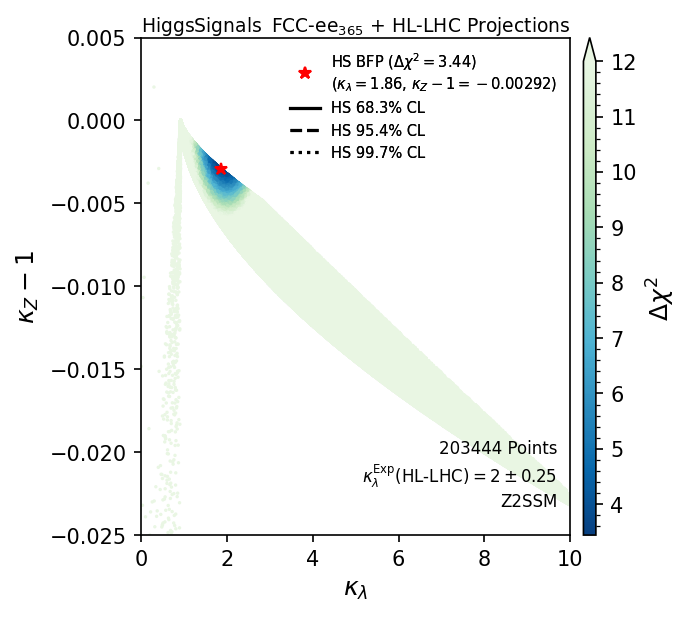

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan_energy_dependence"
plot_dir = "plots"
plot_Z2SSM_bounds(data_file, plot_dir, signals, zoom=True, zoom_range_x=(0, 10), zoom_range_y=(-0.025, 0.005))

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.859003408, (k_Z - 1) = -0.002919128302), with chisq = 3.44
Best scan point row: 74993 out of 203444


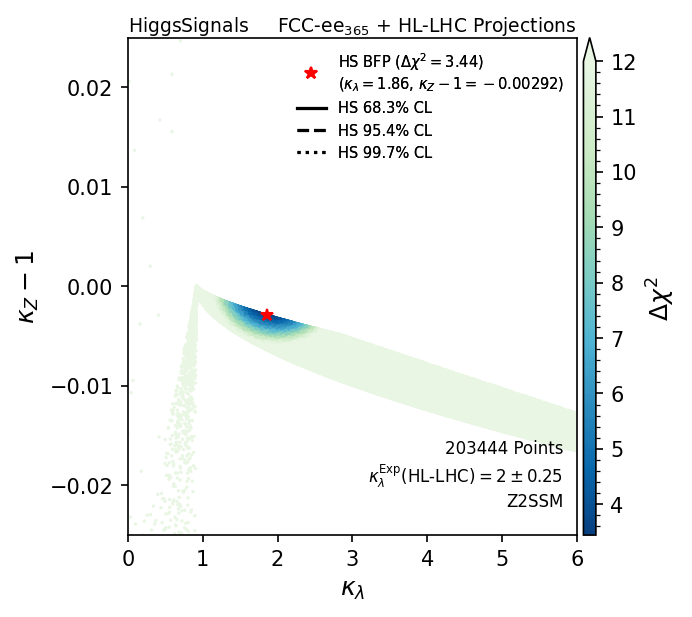

In [27]:
plot_Z2SSM_bounds(data_file, plot_dir, signals, zoom=Truec)

## Tests for different HL-LHC $\kappa_{\lambda}$ pseudo-uncertainties

#### Function for modification the pseudo-uncertainty on $\kappa_{\lambda}$

In [64]:
# os.chdir("/cephfs/user/mrebuzzi/phd/HiggsTools/future_projections")

def modify_kappa_lambda_error(k_lambda_exp_error):
    
    os.system("mkdir modified_measurements")
    os.system("cp -r hsdataset/* modified_measurements/")
    os.chdir("modified_measurements/h125")
    os.system("rm EffLamHL-LHC_LHC13_LHCComb_6000.json")

    bins = {
        "effLam": {
            "coupling": "effLam",
            "obsCoupling": [2 - k_lambda_exp_error, 2, 2 + k_lambda_exp_error],
            # "obsCoupling": [2 - 50./100., 2, 2 + 50./100.],
            "process": {"channels": [[p, "WW"] for p in ("H", "vbfH")]},
        },
    }

    measFile_lam = implementMeasurement(
        "1905.03764",
        "HL-LHC Projection",
        bins,
        # corrMatExp=corrMat,
        prefix="EffLamHL-LHC",
        referenceMass=125.38,
        massResolution=0.15 * 125,  # Change!
        idSuffix=1,
        experiment="LHCComb",
        collider="LHC13",
        luminosity=6000
    )

    os.chdir("../..")


#### Modification and plotting

Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 2, (k_Z - 1) = 0.00329), with chisq = 5.16
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.99, (k_Z - 1) = 0.00321), with chisq = 4.98
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.97, (k_Z - 1) = 0.00316), with chisq = 4.81
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.84, (k_Z - 1) = 0.00289), with chisq = 4.33
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.39, (k_Z - 1) = 0.00179), with chisq = 2.99
Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 0.984, (k_Z - 1) = 0.000445), with chisq = 1.12


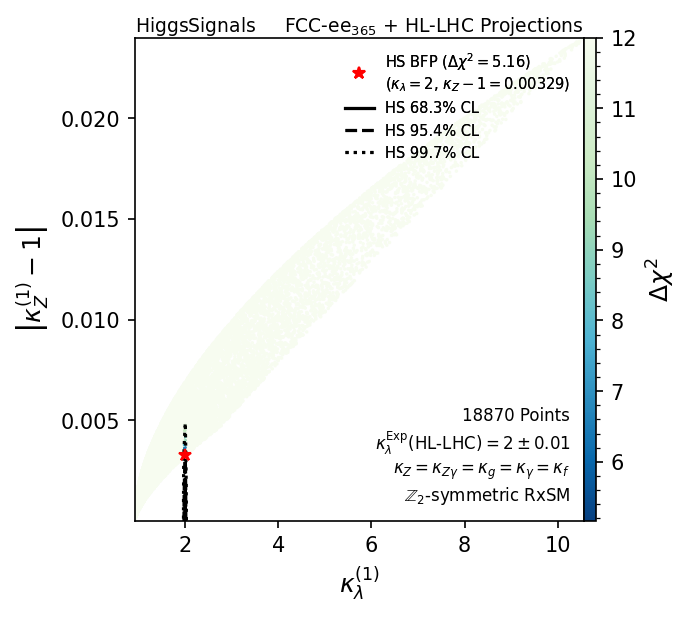

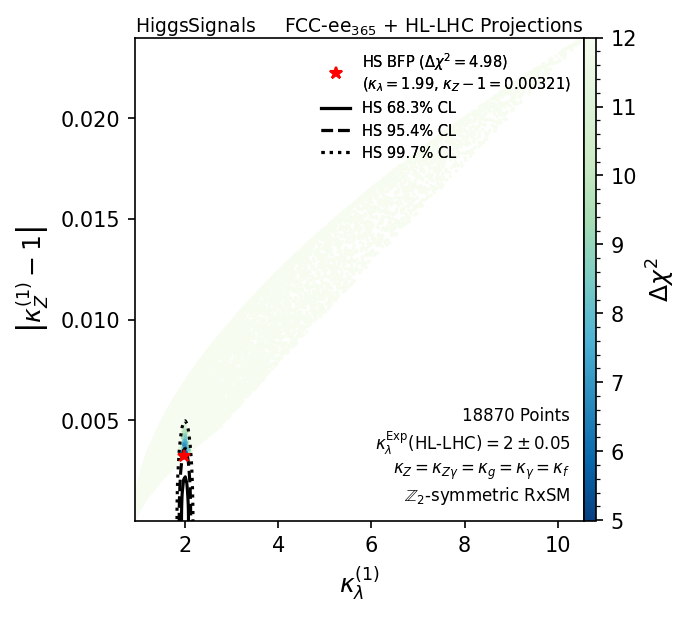

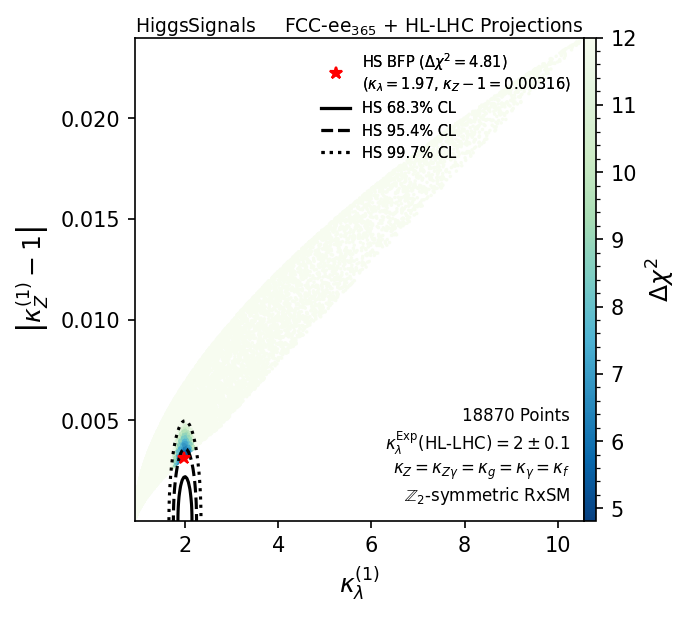

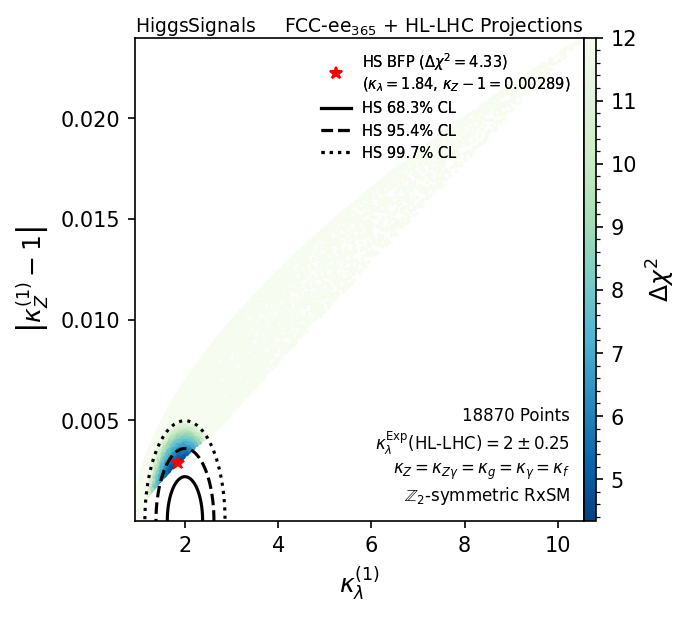

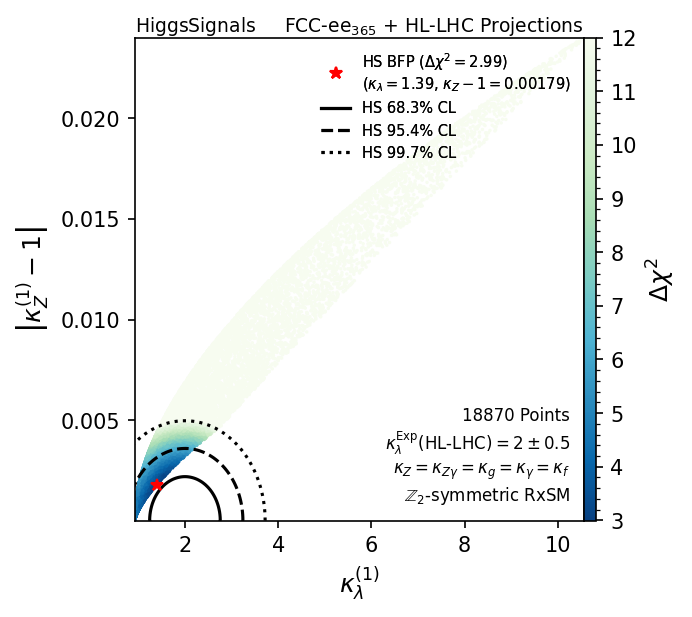

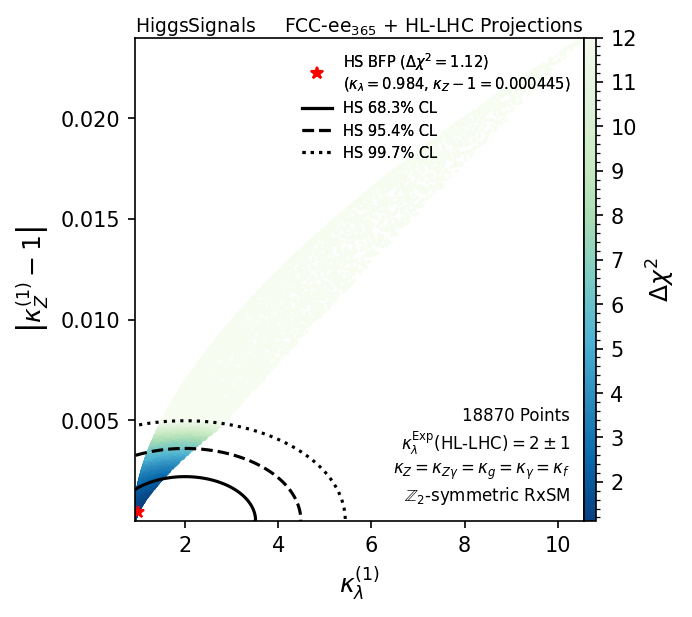

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan"
plot_dir = "plots"
for k_lambda_exp_error in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_lambda_error(k_lambda_exp_error)

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    # coups = HP.scaledSMlikeEffCouplings(1)
    # HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    plot_Z2_RxSM_bounds(data_file, plot_dir, signals_mod, k_lambda_exp_error=k_lambda_exp_error)

os.system("rm -rf modified_measurements")


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 2, (k_Z - 1) = 0.00329), with chisq = 5.16


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.99, (k_Z - 1) = 0.00321), with chisq = 4.98


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.97, (k_Z - 1) = 0.00316), with chisq = 4.81


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.84, (k_Z - 1) = 0.00289), with chisq = 4.33


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 1.39, (k_Z - 1) = 0.00179), with chisq = 2.99


mkdir: cannot create directory ‘modified_measurements’: File exists


Could not detect experiment
Looks good. Saving this to EffLamHL-LHC_LHC13_LHCComb_6000.json
Best scan point: (k_Lamb = 0.984, (k_Z - 1) = 0.000445), with chisq = 1.12


0

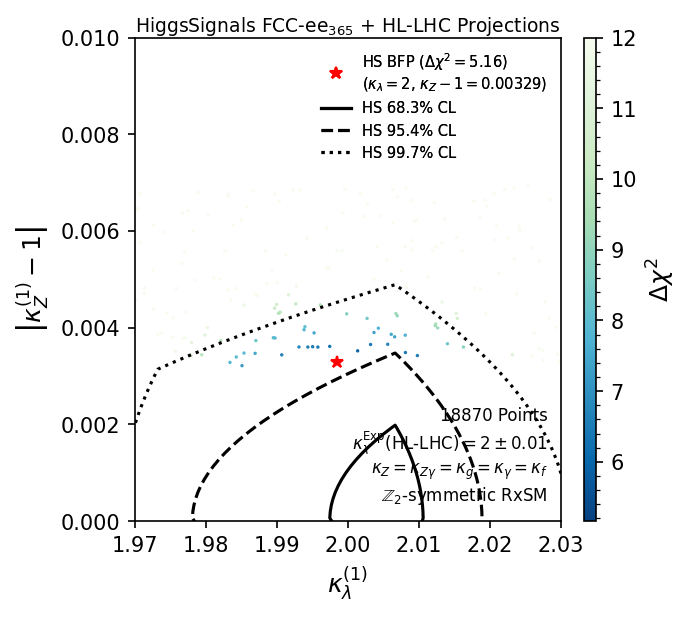

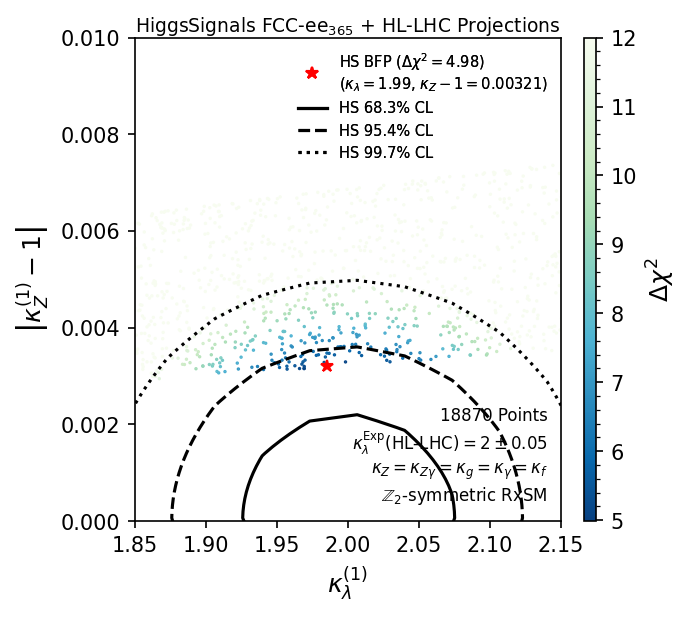

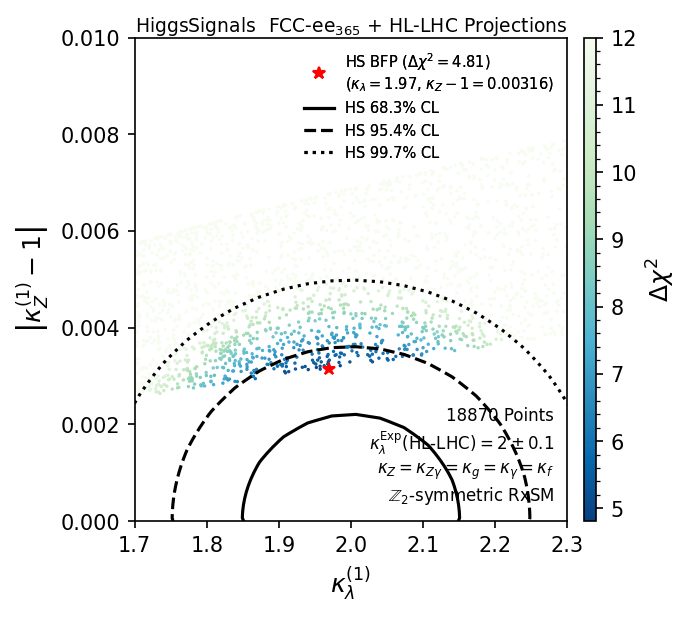

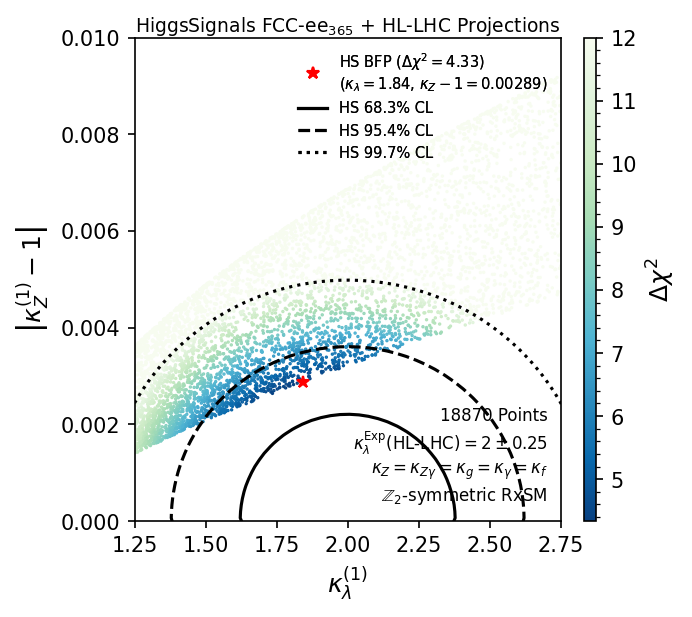

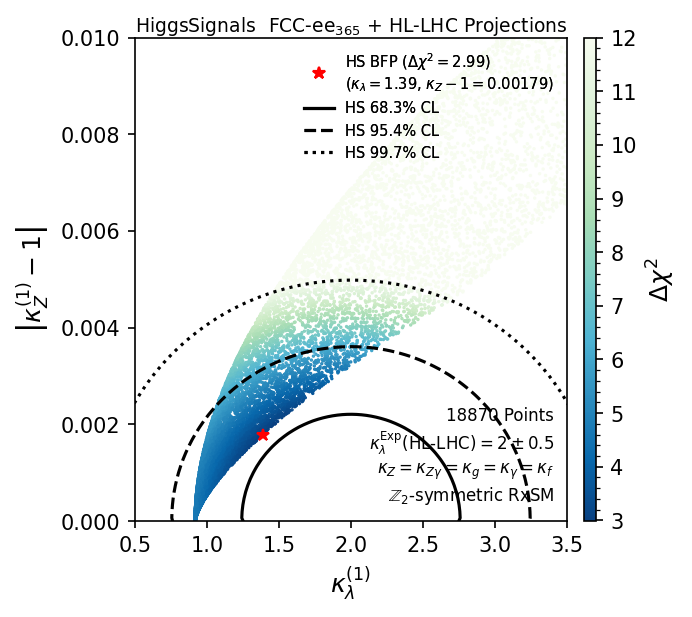

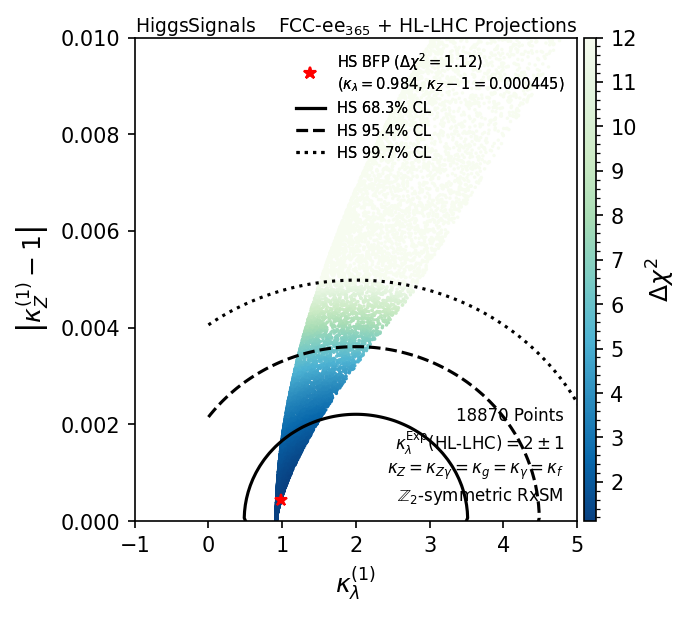

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan"
plot_dir = "plots"
for k_lambda_exp_error in [0.01, 0.05, 0.1, 0.25, 0.5, 1]:
# for k_lambda_exp_error in [0.5]:
    pred = HP.Predictions()
    modify_kappa_lambda_error(k_lambda_exp_error)

    # bounds = HB.Bounds('/Path/To/HBDataSet') # load HB dataset
    signals_mod = HS.Signals('modified_measurements') # load HS dataset

    h = pred.addParticle(HP.NeutralScalar("h", "even"))
    h.setMass(125)

    # coups = HP.scaledSMlikeEffCouplings(1)
    # HP.effectiveCouplingInput(h, coups, reference="SMHiggsEW")
    plot_Z2_RxSM_bounds(data_file, plot_dir, signals_mod, k_lambda_exp_error=k_lambda_exp_error, zoom=True,
                        zoom_range_x=(2 - 3*k_lambda_exp_error, 2 + 3*k_lambda_exp_error))
    
os.system("rm -rf modified_measurements")

# New FCC-ee projections with obtained points

We take the kappa values obtained from the scans and use them as central values for the future projections for FCC-ee measurements, without any direct $\kappa_{\lambda}$ constraint from HL-LHC/ILC

#### Finding the more extreme benchmark point:

In [ ]:
full=True
data_file="data/Z2SSM/Z2_SSM_scan_energy_dependence"
min_lambda = 1.5
max_delta_KZ = 0.01
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)

kappas, EWPOs = read_Z2SSM_file(df)

n_pts = df.shape[0]
chisq = np.full((n_pts,), np.nan)
delta_kZ_240_365 = np.full((n_pts,), np.nan)
for ind in range(n_pts):
    kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
    chisq[ind] = getChisq(kappas_row, signals)
    # delta_kZ_240_365[ind] = np.abs(kappas_row['ZZ_240']**2/kappas_row['ZZ_365']**2 - 1)
    delta_kZ_240_365[ind] = np.abs((kappas_row['ZZ_365'] - kappas_row['ZZ_240'])/(kappas_row['ZZ_240'] - 1))

if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
for ind, (lam, kZ) in enumerate(zip(kappas['lam'], kappas['ZZ'])):
    # if lam < min_lambda: chisq[ind]=1e30
    if lam < min_lambda or np.abs(kZ-1) > max_delta_KZ: delta_kZ_240_365[ind]=1e30

# bfp_index = np.argmin(chisq)
bfp_index = np.argmin(delta_kZ_240_365)
# bfp_chisq = np.min(chisq)
bfp_chisq = chisq[bfp_index]
bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}

for coup, kaps in bfp_kappas.items():
    print(f"kappas['{coup}'] = {kaps}")

print(f"abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])/(bfp_kappas['ZZ_240'] - 1))}")

for obs_name, obs_value in bfp_EWPOs.items():
    print(f"{obs_name} = {obs_value}")

print(f"Best scan point row: {bfp_index+2} out of {len(chisq)+2}")

kappas['lam'] = 4.851894602291084
kappas['uu'] = 0.9900979658931164
kappas['dd'] = 0.9900979658931164
kappas['ss'] = 0.9900979658931164
kappas['cc'] = 0.9900979658931164
kappas['bb'] = 0.9900979658931164
kappas['tt'] = 0.9900979658931164
kappas['ee'] = 0.9900979658931164
kappas['mumu'] = 0.9900979658931164
kappas['tautau'] = 0.9900979658931164
kappas['ZZ'] = 0.9900979658931164
kappas['WW'] = 0.9900979658931164
kappas['gamgam'] = 0.9900979658931164
kappas['Zgam'] = 0.9900979658931164
kappas['gg'] = 0.9900979658931164
kappas['ZZ_0'] = 1.0058431663821037
kappas['ZZ_240'] = 1.0254766435132792
kappas['ZZ_365'] = 1.0027120411448973
kappas['ZZ_500'] = 0.993248029291782
kappas['ZZ_550'] = 0.990843419944736
abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.8935479415299068
Best scan point row: 49259 out of 203446


In [ ]:
full=True
data_file="data/Z2SSM/Z2_SSM_scan_energy_dependence"
min_lambda = 1.2
max_delta_KZ = 0.01
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)

kappas, EWPOs = read_Z2SSM_file(df)

n_pts = df.shape[0]
chisq = np.full((n_pts,), np.nan)
delta_kZ_240_365 = np.full((n_pts,), np.nan)
for ind in range(n_pts):
    kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
    chisq[ind] = getChisq(kappas_row, signals)
    # delta_kZ_240_365[ind] = np.abs(kappas_row['ZZ_240']**2/kappas_row['ZZ_365']**2 - 1)
    delta_kZ_240_365[ind] = np.abs((kappas_row['ZZ_365'] - kappas_row['ZZ_240'])/(kappas_row['ZZ_240'] - 1))

if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
for ind, (lam, kZ) in enumerate(zip(kappas['lam'], kappas['ZZ'])):
    # if lam < min_lambda: chisq[ind]=1e30
    if lam < min_lambda or np.abs(kZ-1) > max_delta_KZ: delta_kZ_240_365[ind]=1e30

# bfp_index = np.argmin(chisq)
bfp_index = np.argmin(delta_kZ_240_365)
# bfp_chisq = np.min(chisq)
bfp_chisq = chisq[bfp_index]
bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}

for coup, kaps in bfp_kappas.items():
    print(f"kappas['{coup}'] = {kaps}")

print(f"abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])/(bfp_kappas['ZZ_240'] - 1))}")

for obs_name, obs_value in bfp_EWPOs.items():
    print(f"{obs_name} = {obs_value}")

print(f"Best scan point row: {bfp_index+2} out of {len(chisq)+2}")

kappas['lam'] = 1.2001128819802882
kappas['uu'] = 0.9966970519699324
kappas['dd'] = 0.9966970519699324
kappas['ss'] = 0.9966970519699324
kappas['cc'] = 0.9966970519699324
kappas['bb'] = 0.9966970519699324
kappas['tt'] = 0.9966970519699324
kappas['ee'] = 0.9966970519699324
kappas['mumu'] = 0.9966970519699324
kappas['tautau'] = 0.9966970519699324
kappas['ZZ'] = 0.9966970519699324
kappas['WW'] = 0.9966970519699324
kappas['gamgam'] = 0.9966970519699324
kappas['Zgam'] = 0.9966970519699324
kappas['gg'] = 0.9966970519699324
kappas['ZZ_0'] = 0.997515043574722
kappas['ZZ_240'] = 0.9985350381741788
kappas['ZZ_365'] = 0.9973523759631301
kappas['ZZ_500'] = 0.9968607034532188
kappas['ZZ_550'] = 0.9967357796543723
abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.8072989959214125
Best scan point row: 115716 out of 203446


### Benchmark points:


In [ ]:
full=True
data_file="data/Z2SSM/Z2_SSM_scan_energy_dependence"
min_lambda = 1.5
max_delta_KZ = 0.01
# n_pts_read = 10_000
n_pts_read = 203445
df = pd.read_csv(data_file + ".csv", skipfooter=203445 - n_pts_read)

df = df.replace("", np.nan)
df = df.dropna().reset_index(drop=True)

kappas, EWPOs = read_Z2SSM_file(df)
n_pts = df.shape[0]

def find_benchmark(BP,
                   min_lambda=-1., 
                   max_lambda=np.inf,
                   max_delta_SingleHiggs=np.inf,
                   absolute_delta_kz=False,
                   maximize_delta_kz=False):

    print(f"\nif BP == \"{BP}\":")
    print(f"\n    # Finding benchmark point {BP}, with constraints:")
    print(f"    # min_lambda = {min_lambda}")
    print(f"    # max_lambda = {max_lambda}")
    print(f"    # max_delta_SingleHiggs = {max_delta_SingleHiggs}")
    print(f"    # absolute_delta_kz = {absolute_delta_kz}")
    print(f"    # maximize_delta_kz = {maximize_delta_kz}\n")

    
    chisq = np.full((n_pts,), np.nan)
    delta_kZ_240_365 = np.full((n_pts,), np.nan)
    for ind in range(n_pts):
        kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
        chisq[ind] = getChisq(kappas_row, signals)

        if not absolute_delta_kz:
            delta_kZ_240_365[ind] = np.abs((kappas_row['ZZ_365'] - kappas_row['ZZ_240'])/(kappas_row['ZZ_240'] - 1))
        else:
            delta_kZ_240_365[ind] = np.abs(kappas_row['ZZ_365'] - kappas_row['ZZ_240'])
        
    if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
        
    for ind, (lam, kZ) in enumerate(zip(kappas['lam'], kappas['ZZ'])):
        if (lam < min_lambda
            or lam > max_lambda 
            or np.abs(kZ-1) > max_delta_SingleHiggs
        ): 
            if not maximize_delta_kz:
                delta_kZ_240_365[ind] = np.inf
            else:
                delta_kZ_240_365[ind] = -1.

    if not maximize_delta_kz:
        bfp_index = np.argmin(delta_kZ_240_365)
    else:
        bfp_index = np.argmax(delta_kZ_240_365)
    bfp_chisq = chisq[bfp_index]
    bfp_kappas = {coup:kps[bfp_index] for (coup, kps) in kappas.items()}
    bfp_EWPOs = {obs_name:obs_value[bfp_index] for (obs_name, obs_value) in EWPOs.items()}

    for coup, kaps in bfp_kappas.items():
        print(f"    kappas['{coup}'] = {kaps}")

    print(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])/(bfp_kappas['ZZ_240'] - 1))}")
    print(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = {np.abs(bfp_kappas['ZZ_365'] - bfp_kappas['ZZ_240'])}")

    for obs_name, obs_value in bfp_EWPOs.items():
        print(f"    {obs_name} = {obs_value}")

    print(f"    # Best scan point row: {bfp_index+2} out of {len(chisq)+2}")

    if delta_kZ_240_365[bfp_index] == np.inf: 
        raise ValueError("Could not find point satisfying the constraints!")


BPs = [{'BP_name' : f'BP_{i}', 
        'min_lambda': 0., 
        'max_lambda': np.inf, 
        'max_delta_SingleHiggs': np.inf,
        'absolute_delta_kz': False,
        'maximize_delta_kz': False,
        } for i in range(8)]


BPs[0]['min_lambda'] = 1.5;  BPs[0]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[0]['max_delta_gamgam'] = 1.5e-2
BPs[1]['min_lambda'] = 1.5;  BPs[1]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[1]['max_delta_gamgam'] = 1.5e-2 ;  BPs[1]['absolute_delta_kz'] = True

# BPs[2]['min_lambda'] = 1.8;  BPs[2]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[2]['max_delta_gamgam'] = 1.5e-2
# BPs[3]['min_lambda'] = 1.8;  BPs[3]['max_delta_SingleHiggs'] = 5e-3 ;  BPs[3]['max_delta_gamgam'] = 1.5e-2 ;  BPs[3]['absolute_delta_kz'] = True

BPs[2]['min_lambda'] = 2.0;  BPs[2]['max_delta_SingleHiggs'] = BPs[2]['max_delta_gamgam'] = 5e-2 ; 
BPs[3]['min_lambda'] = 2.0;  BPs[3]['max_delta_SingleHiggs'] = BPs[3]['max_delta_gamgam'] = 5e-2 ;  BPs[3]['absolute_delta_kz'] = True

BPs[4]['min_lambda'] = 1.5;  BPs[4]['max_delta_SingleHiggs'] = BPs[4]['max_delta_gamgam'] = 5e-2 ; 
BPs[5]['min_lambda'] = 1.5;  BPs[5]['max_delta_SingleHiggs'] = BPs[5]['max_delta_gamgam'] = 5e-2 ;  BPs[5]['absolute_delta_kz'] = True

BPs[6]['max_lambda'] = 1.21; BPs[6]['max_delta_SingleHiggs'] = 1e-2 ; BPs[6]['max_delta_gamgam'] = 2e-2 ;  BPs[6]['maximize_delta_kz'] = True
BPs[7]['max_lambda'] = 1.21; BPs[7]['max_delta_SingleHiggs'] = 1e-2 ; BPs[7]['max_delta_gamgam'] = 2e-2 ;  BPs[7]['maximize_delta_kz'] = True ; BPs[7]['absolute_delta_kz'] = True

# for BP in BPs:
for BP in BPs:
    find_benchmark(BP['BP_name'],
                   BP['min_lambda'], 
                   BP['max_lambda'],
                   BP['max_delta_SingleHiggs'],
                   BP['absolute_delta_kz'],
                   BP['maximize_delta_kz'])


if BP == "BP_0":

    # Finding benchmark point BP_0, with constraints:
    # min_lambda = 1.5
    # max_lambda = inf
    # max_delta_SingleHiggs = 0.005
    # absolute_delta_kz = False
    # maximize_delta_kz = False



KeyboardInterrupt: 

BPs 1 and 5 are the same

BPs 2 and 4 are the same


### Plotting this point

2
[np.float64(2.295748928898636), np.float64(6.180074306244173), np.float64(11.829158081900795)]
Best scan point: (k_Lamb = 1.550997065, (k_Z - 1) = 0.001984595152), with chisq = 6.12
Best scan point row: 579 out of 14048


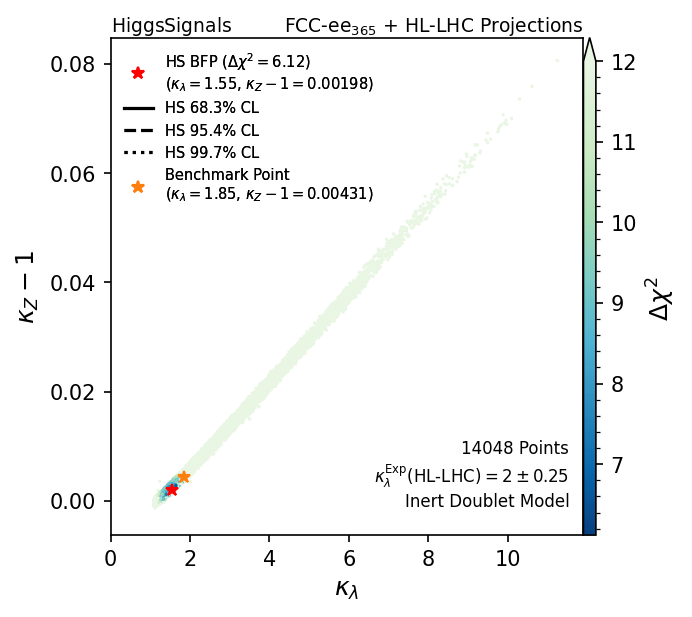

In [ ]:
plot_Z2SSM_bounds(data_file, plot_dir, signals, plot_point=(bfp_kappas['lam'], bfp_kappas['ZZ']-1), zoom_range_x=(0, 5), zoom_range_y=(-0.008, 0.001))

### Plot EffZZH[240] vs EffZZH[365]

In [9]:
def plot_EffZZH_240_vs_365(data_file, 
                           plot_dir, 
                           signals, 
                           k_lambda_exp_error=0.25, 
                           zoom=False, 
                           zoom_range_x=(2 - 3*0.25, 2 + 3*0.25),
                           zoom_range_y=(0.0, 0.005),
                           modified_central=False,
                           ndof=None,
                           chisq_max=12.,
                           plot_points=None,
                           BR_constraints=None,
                           ):
    
    df = pd.read_csv(data_file + ".csv")

    df = df.replace("", np.nan)
    df = df.dropna().reset_index(drop=True)
    n_pts = df.shape[0]
    n_pts_total = n_pts

    kappas, _ = read_Z2SSM_file(df)
    if not BR_constraints is None:

        satisfy_BR_constraint = [True for i in range(n_pts)]
        for i in range(n_pts):
            for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg']:
                if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                    satisfy_BR_constraint[i] = False

        for coup in kappas.keys():
            kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])

        n_pts_BR_constraint = len(kappas['ZZ'])
        print(f"Number of points satisfying the {BR_constraints*100:.3g}% SM constraint on the single higgs couplings: {n_pts_BR_constraint} / {n_pts}")

        n_pts = n_pts_BR_constraint
    
    # chisq = np.full((n_pts,), np.nan)
    # for ind in range(n_pts):
    #     kappas_row = {coup:kps[ind] for (coup, kps) in kappas.items()}
    #     chisq[ind] = getChisq(kappas_row, signals)

    # if any(np.isnan(chisq)): raise ValueError('Wrong chisq!')
    
    # kappas_true = {}
    # for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam', 'gg', "lam"]:
    #     kappas_true[coup] = 1
    # kappas_true["lam"] = 2

    
    color = np.array(kappas['lam'])  ## Color code is now kappa_lambda

    if BR_constraints is None:
        x_data = kappas['ZZ_365'].to_numpy() - 1
        y_data = kappas['ZZ_240'].to_numpy() - 1
    else:
        x_data = kappas['ZZ_365'] - 1
        y_data = kappas['ZZ_240'] - 1

    # xscale = np.max(x_data) - np.min(x_data)
    # yscale = np.max(y_data) - np.min(y_data)
    # scale = np.array([xscale, yscale])

    # mat = np.array([
    #     x_data,
    #     y_data,
    #     color]).T
    
    # grid_points = 300
    # x = np.linspace(2 - 10*(2 - zoom_range_x[0]), 2 + 10*(zoom_range_x[1] - 2), grid_points)
    # y = np.linspace(-0.02, 0.02, grid_points)
    # X, Y = np.meshgrid(x, y)


    fig, ax = plt.subplots(
        figsize=(4.5, 4.),
        constrained_layout=True)

    # Rescaling colormap to avoid too-light points
    # color_map = mpl.colormaps['GnBu_r']
    # color_map = ListedColormap(color_map(np.linspace(0.0, 0.92, 256)))
    color_map = mpl.colormaps['tab20c']

    sc = ax.scatter(
        x_data,
        y_data,
        c=color,
        s=0.4,
        cmap=color_map,
        # vmin=,
        # vmax=chisq_max,
        rasterized=True)

    if zoom==True:
        ax.set_xlim(*zoom_range_x)
        ax.set_ylim(*zoom_range_y)

    clb = fig.colorbar(
        sc,
        ax=ax,
        label=r"$\kappa_\lambda$",
        # ticks=np.arange(0, chisq_max + 1, 1),
        pad=0,
        fraction=0.1,
        location='right',
        aspect=40,
        extend='max',
    )
    clb.ax.minorticks_on()

    # if not ndof:
    #     if modified_central: ndof=1
    #     else: ndof=2
    # print(ndof)
    # levels_123sig = [delta_chi2(n_sigma, dof=ndof) for n_sigma in range(1, 3+1)]
    # print(levels_123sig)

    # ax.contour(
    #     X,
    #     Y,
    #     Z,
    #     levels=levels_123sig,
    #     colors="black",
    #     linestyles=["-", "--", ":"],
    # )

 

    # bfp_index = np.argmin(chisq)
    # bfp_chisq = np.min(chisq)
    # bfp = np.array([kappas['lam'][bfp_index], kappas['ZZ'][bfp_index] - 1])
    # if modified_central: 
    #     plotted_point = list(modified_central)
    #     plotted_point[1] = plotted_point[1] - 1
    # else: plotted_point = bfp

    # ax.plot(
    #     *plotted_point,
    #     marker="*", ls="none", c="r")
    # print(f"Best scan point: (k_Lamb = {bfp[0]:.10g}, (k_Z - 1) = {bfp[1]:.10g}), with chisq = {bfp_chisq:.3g}")
    # print(f"Best scan point row: {bfp_index+2} out of {len(chisq)}")
    # print(f"Best scan point model parameters: muS={df["muS"][bfp_index]}, lamS={df["lamS"][bfp_index]}, lamSH={df["lamSH"][bfp_index]}")


    ax.set_xlabel(r'$\kappa_{ZH}^{365} - 1$')
    ax.set_ylabel(r'$\kappa_{ZH}^{240} - 1$')


    lower_text = r'Z2SSM'

    if BR_constraints:
        lower_text = lower_text + f"\n{BR_constraints*100:.3g}% SM constraints"
        lower_text = lower_text + f"\n{n_pts_BR_constraint} / {n_pts_total} Points"

    else:
        lower_text = lower_text + f'\n{n_pts} Points'+'\n'
    

    # if modified_central:
    #     chisq_SM = getChisq(1, 1, np.inf, signals) - chisq_true
    #     lower_text = fr"$\chi^{2}_{{\text{{SM}}}} = {{{chisq_SM:.2g}}}$ ({chi2_prob_sigma(chisq_SM, ndof):.2g}$\sigma$)"+'\n'+ \
    #                  f'{n_pts} Points'+'\n'+ \
    #                  r'Z2SSM'

    ax.text(
        0.97,
        0.05,
        lower_text,
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes,
        fontsize=8
        )

    ax.text(
        0,
        1,
        r"$\mathrm{HiggsSignals}$",
        horizontalalignment="left",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    if modified_central: text_collider = "FCC-ee$_{{365}}$ Projections"
    else: text_collider = "FCC-ee$_{{365}}$ + HL-LHC Projections"
    ax.text(
        1,
        1,
        text_collider,
        horizontalalignment="right",
        verticalalignment="bottom",
        transform=ax.transAxes,
        fontsize=9,
    )

    
    # if modified_central:
    #     bfp_legend_label = "Central values"+"\n"+f"($\kappa_{{\lambda}}={modified_central[0]:.3g}$, $\kappa_{{Z}}-1={(modified_central[1]-1):.3g}$)"
    # else:
    #     bfp_legend_label = fr"HS BFP ($\Delta\chi^2={bfp_chisq:.3g}$)"+"\n"+f"($\kappa_{{\lambda}}={bfp[0]:.3g}$, $\kappa_{{Z}}-1={bfp[1]:.3g}$)"

    # percent = "\%" if plt.rcParams["text.usetex"] else "%"


    if not plot_points is None:

        leg_handles = []
        # legend_loc='best'
        legend_loc='upper left'

        color = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:pink"]
        colors = mpl.colormaps['tab20b']
        color = color + list(colors(np.linspace(0.001, 0.999, 20)[::-1]))
        for i, plot_point in enumerate(plot_points):

            ax.plot(*(plot_point[:2]), marker="*", ls="none", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5)
            point_label = f"{plot_point[2]}"
            # point_label = f"{plot_point[2]}\n($\kappa_{{\lambda}}={plot_point[0]:.3g}$, $\kappa_{{Z}}-1={plot_point[1]:.3g}$)"
            leg_handles.append(Line2D([0], [0], color="k", ls="none", marker="*", c=color[i], markersize=10, markeredgecolor='white', markeredgewidth=0.5, label=point_label))
            
            # if zoom: legend_loc = 'center right'

        hsLegend = ax.legend(
            handles=leg_handles,
            loc=legend_loc,
            frameon=False,
            prop={'size': 6},
            ncol=2,
        )
        ax.add_artist(hsLegend)


    if BR_constraints:
        plot_name = f'Z2SSM_results_EffZZH_240_vs_365_{BR_constraints:.3g}_SM_constraints'
    else:
        plot_name = f'Z2SSM_results_EffZZH_240_vs_365'

    if not (plot_points is None):
        plot_name = plot_name + "_BPs"
    # if modified_central: plot_name = f'Z2SSM_results_central_{modified_central[0]:.10g}_{modified_central[1]:.10g}'
    if zoom: plot_name = plot_name + "_zoom"
    plt.savefig(f'{plot_dir}/{plot_name}'+".pdf")

Number of points satisfying the 5% SM constraint on the single higgs couplings: 203285 / 203444


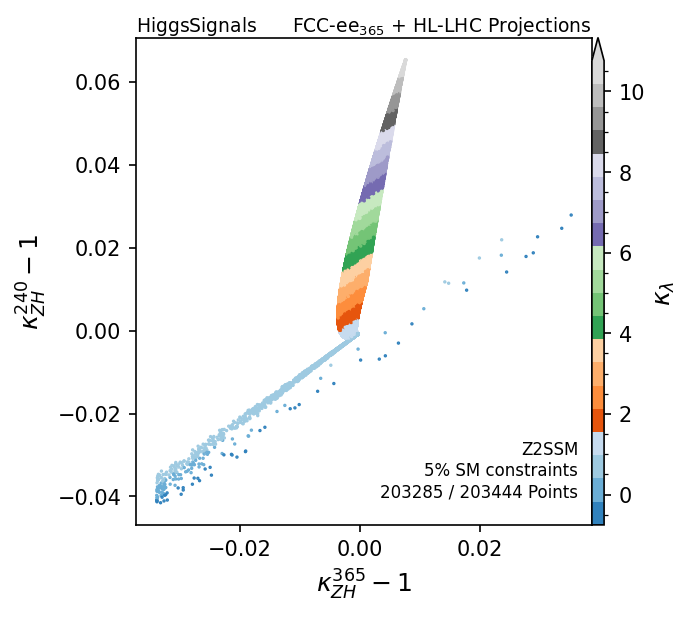

In [ ]:
data_file = "data/Z2SSM/Z2_SSM_scan_energy_dependence"
plot_dir = "plots/Z2SSM"
plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=0.05
                    #    zoom=True,
                    #    zoom_range_x=(-0.002, 0.01), 
                    #    zoom_range_y=(-0.004, 0.01),

                )

### Finding Outlier Points 

In [11]:
import subprocess

In [ ]:
BR_constraints=0.05
data_file="data/Z2SSM/Z2_SSM_scan_energy_dependence"
df = pd.read_csv(data_file + ".csv")

df = df.replace("", np.nan)
df = df.dropna()
old_df_indices = df.index.to_numpy()
df = df.reset_index(drop=True)

kappas, EWPOs = read_Z2SSM_file(df)

def print_to_file(message, file):
    print(message)
    print(message, file=file)

def find_benchmark(df,
                   kappas,
                   EWPOs,
                   old_df_indices,
                   BP_Names,
                   BP_output_file,
                   max_errors_365,
                   max_errors_240,
                   delta_kappas_z_365,
                   delta_kappas_z_240,
                   BR_constraints=None,
                   ):


    n_pts = df.shape[0]
    chisq = np.full((n_pts,), np.nan)
    delta_kZ_240_365 = np.full((n_pts,), np.nan)

    if not BR_constraints is None:
        satisfy_BR_constraint = [True for i in range(n_pts)]
        for i in range(n_pts):
            for coup in ['uu', 'dd', 'cc', 'ss', 'tt', 'bb', 'ee', 'mumu', 'tautau', 'WW', 'ZZ', 'Zgam', 'gamgam']:
                if np.abs(kappas[coup][i] - 1.) > BR_constraints:
                    satisfy_BR_constraint[i] = False

        for coup in kappas.keys():
            kappas[coup] = np.array(kappas[coup][satisfy_BR_constraint])
        
        for ewpo in EWPOs.keys():
            EWPOs[ewpo] = np.array(EWPOs[ewpo][satisfy_BR_constraint])

        old_df_indices = old_df_indices[satisfy_BR_constraint]
        

    if not len(delta_kappas_z_365) == len(delta_kappas_z_240):
        raise ValueError("delta_kappas_z_365 and delta_kappas_z_240 have different lengths!")

    bp_indices = [None for i in range(len(delta_kappas_z_365))]
    bp_kappas = [None for i in range(len(delta_kappas_z_365))]
    bp_EWPOs = [None for i in range(len(delta_kappas_z_365))]

    for ind, (kZ_365, kZ_240) in enumerate(zip(kappas['ZZ_365'], kappas['ZZ_240'])):
        for BP, (delta_kappa_z_365, delta_kappa_z_240, max_error_365, max_error_240) in enumerate(zip(delta_kappas_z_365, delta_kappas_z_240, max_errors_365, max_errors_240)):
            if abs((kZ_365-1) - delta_kappa_z_365) < max_error_365 and abs((kZ_240-1) - delta_kappa_z_240) < max_error_240:
                bp_indices[BP] = ind


    if any(bp_index is None for bp_index in bp_indices):
        missing_BPs = [i for i, bp_index in enumerate(bp_indices) if bp_index is None]
        raise ValueError(f"The following BPs were not found: {missing_BPs}")


    for BP, bp_index in enumerate(bp_indices):

        print_to_file(f"\nelif BP == \"{BP_Names[BP]}\":", file=BP_output_file)

        # bfp_chisq = chisq[bp_index]
        bp_kappas[BP] = {coup:kps[bp_index] for (coup, kps) in kappas.items()}
        bp_EWPOs[BP] = {obs_name:obs_value[bp_index] for (obs_name, obs_value) in EWPOs.items()}

        for coup, kaps in bp_kappas[BP].items():
            print_to_file(f"    kappas['{coup}'] = {kaps}", file=BP_output_file)

        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = {np.abs((bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])/(bp_kappas[BP]['ZZ_240'] - 1))}", file=BP_output_file)
        print_to_file(f"    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = {np.abs(bp_kappas[BP]['ZZ_365'] - bp_kappas[BP]['ZZ_240'])}", file=BP_output_file)

        for obs_name, obs_value in bp_EWPOs[BP].items():
            print_to_file(f"    {obs_name} = {obs_value}", file=BP_output_file)

        print_to_file(f"    # Best scan point row: {bp_index+2} out of {len(kappas['ZZ_240'])+2}", file=BP_output_file)

        if delta_kZ_240_365[bp_index] == np.inf: 
            raise ValueError("Could not find point satisfying the constraints!")
        
    return bp_kappas


output_dir = "./scan_output/Z2SSM_scan_output"
subprocess.run(["mkdir", "-p", output_dir])

BP_filename = f"{output_dir}/Benchmark_Points_outliers.txt"
with open(BP_filename, "w") as BP_output_file:

    max_errors_365 = [2e-3, 2e-3, 2e-3, 2e-3, 1e-3, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4, 1e-4, 2e-4, 2e-4, 2e-4, 2e-4, 2e-4,]
    max_errors_240 = [2e-3, 2e-3, 2e-3, 2e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3,]
    delta_kappas_z_365 = [0.035, 0.018, -0.007, -0.035, -0.0345, -0.002, -0.0032, -0.0001, -0.002, 0.00145, -0.0004, 0.0030, 0.0016, 0.0042, 0.0036, 0.0062, 0.0056, 0.0075]
    delta_kappas_z_240 = [0.027, 0.008, -0.015, -0.042, -0.034,  -0.003,  0.0125, -0.0015 , 0.021, 0.0122,   0.030,  0.0253, 0.0395, 0.0390, 0.049,  0.052, 0.058,  0.066]

    BP_Names = ["BPO_0", "BPO_1", "BPO_2", "BPO_3", "BPO_4"]
    BP_Names = BP_Names + [f"BPB_{i}" for i in range(len(delta_kappas_z_240)-2)]
    BP_Names_legend = ["BPO 0", "BPO 1", "BPO 2", "BPO 3", "BPO 4"]
    BP_Names_legend = BP_Names_legend + [f"BPB {i}" for i in range(len(delta_kappas_z_240)-2)]

    bp_kappas = find_benchmark(df=df,
                               EWPOs=EWPOs,
                               kappas=kappas,
                               old_df_indices=old_df_indices,
                               BP_Names=BP_Names,
                               BP_output_file=BP_output_file,
                               max_errors_365=max_errors_365,
                               max_errors_240=max_errors_240,
                               delta_kappas_z_365=delta_kappas_z_365,
                               delta_kappas_z_240=delta_kappas_z_240,
                              )


elif BP == "BPO_0":
    kappas['lam'] = -0.2508742207313748
    kappas['uu'] = 1.0393799170799365
    kappas['dd'] = 1.0393799170799365
    kappas['ss'] = 1.0393799170799365
    kappas['cc'] = 1.0393799170799365
    kappas['bb'] = 1.0393799170799365
    kappas['tt'] = 1.0393799170799365
    kappas['ee'] = 1.0393799170799365
    kappas['mumu'] = 1.0393799170799365
    kappas['tautau'] = 1.0393799170799365
    kappas['ZZ'] = 1.0393799170799365
    kappas['WW'] = 1.0393799170799365
    kappas['gamgam'] = 1.0393799170799365
    kappas['Zgam'] = 1.0393799170799365
    kappas['gg'] = 1.0393799170799365
    kappas['ZZ_0'] = 1.0342667799291414
    kappas['ZZ_240'] = 1.0278909537598329
    kappas['ZZ_365'] = 1.0352835896411137
    kappas['ZZ_500'] = 1.0383569573404057
    kappas['ZZ_550'] = 1.0391378364021953
    # abs(kappas['ZZ_365'] - kappas['ZZ_240'])/(kappas['ZZ_240'] - 1) = 0.2650549688955889
    # abs(kappas['ZZ_365'] - kappas['ZZ_240']) = 0.007392635881280807
    # Best scan point row:

In [16]:
print("std::vector<float> base_KappaLambdas = {")
for BP, BP_name in zip(bp_kappas, BP_Names):
    print(f"        {BP["lam"]}, // {BP_name}")
print("    };")

std::vector<float> base_KappaLambdas = {
        -0.2508742207313748, // BPO_0
        -0.3647055096736148, // BPO_1
        -0.283207588738505, // BPO_2
        -0.2265153925052781, // BPO_3
        0.8270343237975535, // BPO_4
        0.8918170746898771, // BPB_0
        3.4771963023861323, // BPB_1
        0.9196804937486558, // BPB_2
        4.703937706690645, // BPB_3
        3.013431564284278, // BPB_4
        5.946907598934937, // BPB_5
        4.968691068740802, // BPB_6
        7.233411757176534, // BPB_7
        6.988652545078013, // BPB_8
        8.519243114238716, // BPB_9
        8.915995818716492, // BPB_10
        9.679739818437092, // BPB_11
        10.721334023900692, // BPB_12
    };


### Plotting the obtained points

Number of points satisfying the 5% SM constraint on the single higgs couplings: 203285 / 203444


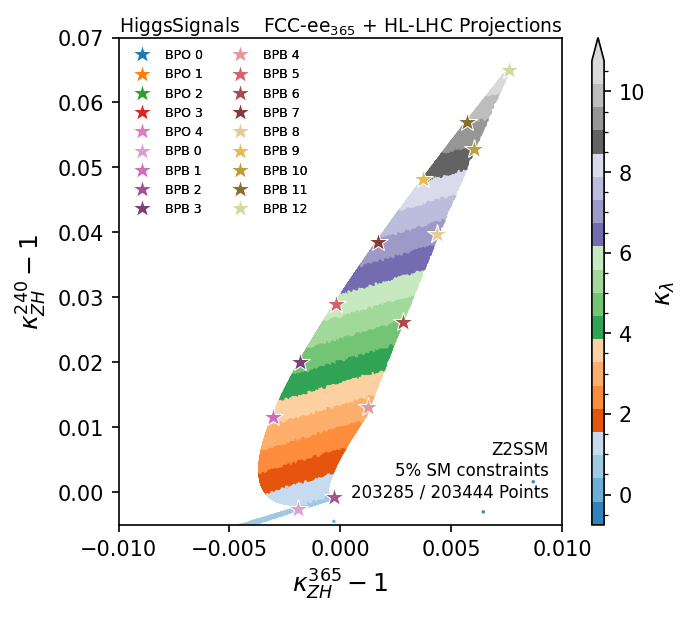

In [ ]:
# data_file = "data/Z2SSM/Z2_SSM_scan_energy_dependence"
plot_dir = "plots/Z2SSM"
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                       zoom=True,
                       zoom_range_x=(-0.01, 0.01),
                       zoom_range_y=(-0.005, 0.07),
                )

Number of points satisfying the 5% SM constraint on the single higgs couplings: 203285 / 203444


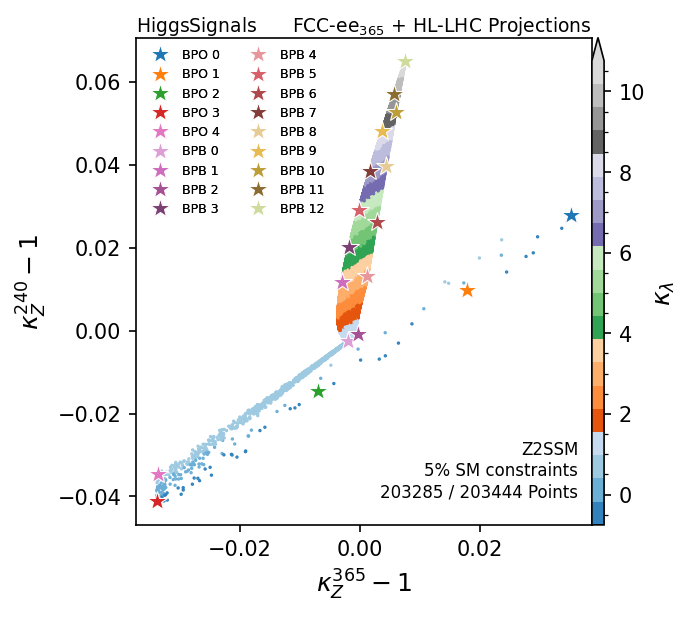

In [ ]:
# data_file = "data/Z2SSM/Z2_SSM_scan_energy_dependence"
plot_dir = "plots/Z2SSM"
BR_constraints = 0.05
plot_points = [(BP["ZZ_365"]-1, BP["ZZ_240"]-1, label) for BP, label in zip(bp_kappas, BP_Names_legend)]

plot_EffZZH_240_vs_365(data_file, plot_dir, signals, 
                       BR_constraints=BR_constraints,
                       plot_points=plot_points,
                )

#### Generate latex code for slides

In [17]:
list_BPs = list(range(8))
list_BPs.remove(2)
list_BPs.remove(4)
for i in list_BPs:

    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(rf"%%%%%%%%%%%%%%% BP {i} %%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"")
    print(r"\begin{frame}{FCC-ee results: Z2SSM Benchmark Point "+f"{i}"+"}")
    print(r"    \begin{columns}")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_BP_"+f"{i}"+"_Z2SSM_FCCee240.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_BP_"+f"{i}"+"_Z2SSM_FCCee240_FCCee365.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"        ")
    print(r"        ")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.5cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={3mm, 3mm, 3mm, 2mm}, clip, width=0.95\textwidth]{comparison_plots/Z2SSM/FCC_results/mean_stddev_0.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.5cm}")
    print(r"            ")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"    \end{columns}")
    print(r"\end{frame}")
    print("\n")
    print("\n")

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% BP 0 %%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{FCC-ee results: Z2SSM Benchmark Point 0}
    \begin{columns}
        \begin{column}{.50\textwidth}
            \vspace{-0.4cm}
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_BP_0_Z2SSM_FCCee240.pdf}
            \centering
            \vspace{0.2cm}
            
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_BP_0_Z2SSM_FCCee240_FCCee365.pdf}
            \centering
            \end{figure}
        \end{column}
        
        
        \begin{column}{.50\textwidth}
            \vspace{-0.

In [19]:
num_BPO = 2
num_BPB = 17
def generate_slide(BP, BP_name):

    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(rf"%%%%%%%%%%%%%%% {BP_name} %%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print(r"")
    print(r"\begin{frame}{FCC-ee results: Z2SSM Benchmark Point "+f"{BP_name}"+"}")
    print(r"    \begin{columns}")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.4cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_"+BP+"_Z2SSM_FCCee240.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.2cm}")
    print(r"            ")
    print(r"            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_"+BP+"_Z2SSM_FCCee240_FCCee365.pdf}")
    print(r"            \centering")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"        ")
    print(r"        ")
    print(r"        \begin{column}{.50\textwidth}")
    print(r"            \vspace{-0.5cm}")
    print(r"            \centering")
    print(r"            \begin{figure}[h]")
    print(r"            \centering")
    print(r"            % trim={<left> <lower> <right> <upper>}")
    print(r"            \includegraphics[trim={3mm, 3mm, 3mm, 2mm}, clip, width=0.95\textwidth]{comparison_plots/Z2SSM/FCC_results/mean_stddev_0.pdf}")
    print(r"            \centering")
    print(r"            \vspace{0.5cm}")
    print(r"            ")
    print(r"            \end{figure}")
    print(r"        \end{column}")
    print(r"    \end{columns}")
    print(r"\end{frame}")
    print("\n")
    print("\n")

for i in range(num_BPO):
    generate_slide(f"BPO_{i}", f"BPO {i}")

for i in range(num_BPB):
    generate_slide(f"BPB_{i}", f"BPB {i}")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% BPO 0 %%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{FCC-ee results: Z2SSM Benchmark Point BPO 0}
    \begin{columns}
        \begin{column}{.50\textwidth}
            \vspace{-0.4cm}
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_BPO_0_Z2SSM_FCCee240.pdf}
            \centering
            \vspace{0.2cm}
            
            \includegraphics[trim={5mm, 3mm, 3mm, 2mm}, clip, width=0.90\textwidth]{comparison_plots/Z2SSM/FCC_results/deltalHHH_HLLHC_BPO_0_Z2SSM_FCCee240_FCCee365.pdf}
            \centering
            \end{figure}
        \end{column}
        
        
        \begin{column}{.50\textwidth}
            \vsp

In [10]:
import math

In [24]:
n_obs = 53
nvar_per_plot = 2
n_plots = math.ceil(n_obs/nvar_per_plot)

nplots_per_slide=2
n_slides = math.ceil(n_plots/nplots_per_slide)

slide_breaks = np.arange(0, n_plots, nplots_per_slide)
if slide_breaks[-1] != n_plots:
    slide_breaks = np.append(slide_breaks, [n_plots])

for slide in range(n_slides):

    if slide_breaks[slide]== n_plots-1:
        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}[noframenumbering]{Z2SSM - Single Higgs Observables ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    ")
        print(r"    \centering")
        print(r"    \begin{figure}[h]")
        print(r"    \centering")
        print(r"    % trim={<left> <lower> <right> <upper>}")
        print(r"    \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.8\textwidth]{comparison_plots/Z2SSM/FCC_results/mean_stddev_"+f"{n_plots-1}"+".pdf}")
        print(r"")
        print(r"    \end{figure}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")

    else:
        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}[noframenumbering]{Z2SSM - Single Higgs Observables ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    \begin{columns}")

        for plot in np.arange(slide_breaks[slide],slide_breaks[slide+1]):
            print(r"        \begin{column}{.5\textwidth}")
            print(r"            ")
            print(r"            \centering")
            print(r"            \begin{figure}[h]")
            print(r"            \centering")
            print(r"            % trim={<left> <lower> <right> <upper>}")
            print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{comparison_plots/Z2SSM/FCC_results/mean_stddev_"+f"{plot}"+r".pdf}")
            print(r"")
            print(r"            \end{figure}")
            print(r"        \end{column}")

        print(r"    \end{columns}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% 1 %%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}[noframenumbering]{Z2SSM - Single Higgs Observables (1)}
\vspace{-0.4cm}
    \begin{columns}
        \begin{column}{.5\textwidth}
            
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{comparison_plots/Z2SSM/FCC_results/mean_stddev_0.pdf}

            \end{figure}
        \end{column}
        \begin{column}{.5\textwidth}
            
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{comparison_plots/Z2SSM/FCC_results/mean_stddev_1.pdf}

            \end{figure}
        \end{column}
    \end{columns}

\end{frame}





%%%%%%%%%%%%%%%%%%%%

### Now for the large_kappa_lambda_fits

In [14]:
n_obs = 53
nvar_per_plot = 2
n_plots = math.ceil(n_obs/nvar_per_plot)

nplots_per_slide=2
n_slides = math.ceil(n_plots/nplots_per_slide)

slide_breaks = np.arange(0, n_plots, nplots_per_slide)
if slide_breaks[-1] != n_plots:
    slide_breaks = np.append(slide_breaks, [n_plots])

for slide in range(n_slides):

    if slide_breaks[slide]== n_plots-1:
        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}{Cross-check Fits - Single Higgs Observables ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    ")
        print(r"    \centering")
        print(r"    \begin{figure}[h]")
        print(r"    \centering")
        print(r"    % trim={<left> <lower> <right> <upper>}")
        print(r"    \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.8\textwidth]{cross_checks/high_kappa_lambda/FCCee/mean_stddev_"+f"{n_plots-1}"+".pdf}")
        print(r"")
        print(r"    \end{figure}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")

    else:
        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}{Cross-check Fits - Single Higgs Observables ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    \begin{columns}")

        for plot in np.arange(slide_breaks[slide],slide_breaks[slide+1]):
            print(r"        \begin{column}{.5\textwidth}")
            print(r"            ")
            print(r"            \centering")
            print(r"            \begin{figure}[h]")
            print(r"            \centering")
            print(r"            % trim={<left> <lower> <right> <upper>}")
            print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{cross_checks/high_kappa_lambda/FCCee/mean_stddev_"+f"{plot}"+r".pdf}")
            print(r"")
            print(r"            \end{figure}")
            print(r"        \end{column}")

        print(r"    \end{columns}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% 1 %%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{Cross-check Fits - Single Higgs Observables (1)}
\vspace{-0.4cm}
    \begin{columns}
        \begin{column}{.5\textwidth}
            
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{cross_checks/high_kappa_lambda/FCCee/mean_stddev_0.pdf}

            \end{figure}
        \end{column}
        \begin{column}{.5\textwidth}
            
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=1.\textwidth]{cross_checks/high_kappa_lambda/FCCee/mean_stddev_1.pdf}

            \end{figure}
        \end{column}
    \end{columns}

\end{frame}





%%%%%%%%%%%%%%%%%%%%%%%

In [22]:
list_kappas = [[2,3,5,6,],[7,8,9,10]]
n_slides = 2
for slide in range(n_slides):

        print(r"")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%% "+f"{slide+1}"+r" %%%%%%%%%%%%%%%%%%%")
        print(r"%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
        print(r"")
        print(r"\begin{frame}{Cross-check Fits - (\kala-1) Distributions ("+f"{slide+1}"+r")}")
        print(r"\vspace{-0.4cm}")
        print(r"    \begin{columns}")

    
        print(r"        \begin{column}{.5\textwidth}")
        print(r"            ")
        print(r"            \vspace{-0.0cm}")
        print(r"            \centering")
        print(r"            \begin{figure}[h]")
        print(r"            \centering")
        print(r"            % trim={<left> <lower> <right> <upper>}")
        print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.95\textwidth]{cross_checks/high_kappa_lambda/FCCee/deltalHHH_HLLHC_Lambda"+f"{list_kappas[slide][0]}"+"_FCCee240_FCCee365_noHLLHClambda.pdf}")
        print(r"")
        print(r"            \centering")
        print(r"            % trim={<left> <lower> <right> <upper>}")
        print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.95\textwidth]{cross_checks/high_kappa_lambda/FCCee/deltalHHH_HLLHC_Lambda"+f"{list_kappas[slide][2]}"+"_FCCee240_FCCee365_noHLLHClambda.pdf}")
        print(r"")
        print(r"            \end{figure}")
        print(r"        \end{column}")


        print(r"        \begin{column}{.5\textwidth}")
        print(r"            ")
        print(r"            \vspace{-0.0cm}")
        print(r"            \centering")
        print(r"            \begin{figure}[h]")
        print(r"            \centering")
        print(r"            % trim={<left> <lower> <right> <upper>}")
        print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.95\textwidth]{cross_checks/high_kappa_lambda/FCCee/deltalHHH_HLLHC_Lambda"+f"{list_kappas[slide][1]}"+"_FCCee240_FCCee365_noHLLHClambda.pdf}")
        print(r"")
        print(r"            \centering")
        print(r"            % trim={<left> <lower> <right> <upper>}")
        print(r"            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.95\textwidth]{cross_checks/high_kappa_lambda/FCCee/deltalHHH_HLLHC_Lambda"+f"{list_kappas[slide][3]}"+"_FCCee240_FCCee365_noHLLHClambda.pdf}")
        print(r"")
        print(r"            \end{figure}")
        print(r"        \end{column}")


        print(r"    \end{columns}")
        print(r"")
        print(r"\end{frame}")
        print("\n")
        print("\n")


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%% 1 %%%%%%%%%%%%%%%%%%%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

\begin{frame}{Cross-check Fits - (\kala-1) Distributions (1)}
\vspace{-0.4cm}
    \begin{columns}
        \begin{column}{.5\textwidth}
            
            \vspace{-0.0cm}
            \centering
            \begin{figure}[h]
            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.95\textwidth]{cross_checks/high_kappa_lambda/FCCee/deltalHHH_HLLHC_Lambda2_FCCee240_FCCee365_noHLLHClambda.pdf}

            \centering
            % trim={<left> <lower> <right> <upper>}
            \includegraphics[trim={0mm, 0mm, 0mm, 0mm}, clip, width=0.95\textwidth]{cross_checks/high_kappa_lambda/FCCee/deltalHHH_HLLHC_Lambda5_FCCee240_FCCee365_noHLLHClambda.pdf}

            \end{figure}
        \end{column}
        \begin{column}{.5\textwidth}
            
            \vspace{-0.0cm}
            \ce